### Installing required libraries:
 - transformers: for pre-trained models (e.g., BLIP for image captioning)
- sacrebleu: for BLEU score evaluation of generated captions
- pillow: for image handling and preprocessing


In [1]:
!pip install -q transformers sacrebleu pillow sacrebleu


In [2]:
# Install & Imports

import os
import random
import copy
from pathlib import Path
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import math
import time

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim

from transformers import BlipProcessor, BlipForConditionalGeneration
import sacrebleu

from sklearn.model_selection import train_test_split


# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


### Mount Google Drive & Load Dataset  
We mount Google Drive to access project files stored there.  
- Define the root directory (`DRIVE_ROOT`) where data is stored.  
- Load the **captions CSV** (contains image paths and corresponding captions).  
- Preview the dataset and print the total number of rows.  


In [3]:
from google.colab import drive
drive.mount('/content/drive')

DRIVE_ROOT = "/content/drive/MyDrive/690F"
CSV_PATH = os.path.join(DRIVE_ROOT, "captions.csv")

df_all = pd.read_csv(CSV_PATH)
print("Total rows in CSV:", len(df_all))
df_all.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total rows in CSV: 102


filename class  \
0  data/synthetic/images/dogs/dog1.jpg  dogs   
1  data/synthetic/images/dogs/dog2.jpg  dogs   
2  data/synthetic/images/dogs/dog3.jpg  dogs   
3  data/synthetic/images/dogs/dog4.jpg  dogs   
4  data/synthetic/images/dogs/dog5.jpg  dogs   

                                              prompt  \
0  Photorealistic single dog on a porch step, eye...   
1  Photorealistic single dog lying on a living-ro...   
2  Photorealistic single puppy on grass in a park...   
3  Photorealistic single dog sitting by a window ...   
4  Photorealistic single dog on a plain studio fl...   

                                             caption  
0  Single dog on a porch step, eye-level, golden ...  
1             Single dog lying on a living-room rug.  
2                   Single puppy on grass in a park.  
3            Single dog sitting by a window indoors.  
4                Single dog on a plain studio floor.

### Configuration & Data Splitting  

In [4]:
# Config
NUM_CLIENTS = 5         # >=5 as required
# PARTITION_TYPE = "non-iid"  # "iid" or "non-iid"
NUM_ROUNDS = 5          # federated rounds
# LOCAL_EPOCHS = 1       # local epochs per round
LOCAL_BATCH = 4
LR = 5e-5
MAX_TARGET_LENGTH = 32   # tokens for captions
CENTRALIZED_EPOCHS = 5   # epochs for centralized baseline
SEED = 42

import numpy as np

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Train/test split: sequence or random
train_df, test_df = train_test_split(df_all, test_size=0.2, random_state=SEED, shuffle=True)

print("Train samples:", len(train_df), "Test samples:", len(test_df))


Train samples: 81 Test samples: 21


In [5]:
train_df.head()

filename     class  \
53          data/synthetic/images/book/book4.jpg      book   
22          data/synthetic/images/food/food3.jpg      food   
68  data/synthetic/images/painting/painting9.jpg  painting   
44          data/synthetic/images/room/room5.jpg      room   
98    data/synthetic/images/flowers/flowers9.jpg   flowers   

                                               prompt  \
53  Photorealistic close-up of a single book cover...   
22  Photorealistic burger on a slate board, 3/4 vi...   
68  Photorealistic framed painting on a wall, low-...   
44  Photorealistic wide shot of a bedroom with min...   
98  Photorealistic carnation macro with shallow DO...   

                                       caption  
53                        A single book cover.  
22                    Burger on a slate board.  
68                  Framed painting on a wall.  
44  Wide shot of a bedroom with minimal décor.  
98                            Carnation macro.

In [6]:
test_df.head()

filename     class  \
30        data/synthetic/images/drink/drink1.jpg     drink   
67  data/synthetic/images/painting/painting8.jpg  painting   
62  data/synthetic/images/painting/painting3.jpg  painting   
47          data/synthetic/images/room/room8.jpg      room   
42          data/synthetic/images/room/room3.jpg      room   

                                               prompt  \
30  Photorealistic latte in a ceramic mug on café ...   
67  Photorealistic framed painting on a wall, eye-...   
62  Photorealistic framed painting on a wall, low-...   
47  Photorealistic wide shot of a bedroom with win...   
42  Photorealistic wide shot of a study with desk ...   

                                       caption  
30       Latte in a ceramic mug on café table.  
67                  Framed painting on a wall.  
62                  Framed painting on a wall.  
47  Wide shot of a bedroom with window drapes.  
42   Wide shot of a study with desk and chair.

### Image Caption Dataset & Collate Function  

- **`ImageCaptionDataset`**: Custom PyTorch dataset to handle image-caption pairs from the CSV.  
  - Loads images from Google Drive using the `"filename"` column.  
  - Returns a dictionary with image path and corresponding caption.  

- **`collate_fn`**: Custom collate function for the DataLoader, tailored for BLIP models.  
  - Converts image paths to PIL images and ensures they are in RGB format.  
  - Handles missing or unreadable images by replacing them with blank images.  
  - Returns a batch as a dictionary containing lists of images, captions, and image paths.  

> Note: BLIP expects batches as lists of PIL images and corresponding text captions, not tensors.  


In [7]:
class ImageCaptionDataset(Dataset):
    def __init__(self, df, drive_root=DRIVE_ROOT):
        self.df = df.reset_index(drop=True)
        self.drive_root = drive_root

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # CSV has a column "filename" that is path relative to DRIVE_ROOT
        img_path = os.path.join(self.drive_root, str(row["filename"]))
        caption = str(row["caption"])
        return {"image_path": img_path, "caption": caption}

def collate_fn(batch):
    images = []
    captions = []
    image_paths = []
    for item in batch:
        img_path = item["image_path"]
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Warning: cannot open {img_path}: {e}. Using blank image.")
            img = Image.new("RGB", (224,224), color=(0,0,0))
        images.append(img)
        captions.append(item["caption"])
        image_paths.append(img_path)
    return {"images": images, "captions": captions, "image_paths": image_paths}


### Create IID / Non-IID Client Partitions  

This cell splits the training dataset into `NUM_CLIENTS` separate partitions for federated learning:  

- **IID partitioning**: randomly shuffles data and distributes it evenly across all clients.  
- **Non-IID partitioning**: assigns consecutive chunks to clients (simulating label or feature skew).  
  - Useful to test federated learning under heterogeneous client data.  

- Returns a list of indices for each client.  
- Prints the size of each client partition to ensure correct distribution.  

> Each client will later use its own partition to train locally, simulating real-world FL scenarios.  


In [8]:
def create_client_partitions(df, dataset_size, num_clients=NUM_CLIENTS, partition_type="", seed=SEED):
    indices = list(range(dataset_size))
    rng = random.Random(seed)

    # Compute base size and remainder
    base = dataset_size // num_clients
    rem = dataset_size % num_clients

    # Precompute sizes for all clients (last client gets the remainder)
    client_sizes = [base] * num_clients
    client_sizes[-1] += rem  # remainder goes to last client

    if partition_type == "iid":
        rng.shuffle(indices)
    elif partition_type != "non-iid":
        raise ValueError("partition_type must be 'iid' or 'non-iid'")

    partitions = []
    start = 0
    for size in client_sizes:
        end = start + size
        partitions.append(indices[start:end])
        start = end

    return partitions


In [9]:
partitions_noniid = create_client_partitions(train_df, len(train_df), NUM_CLIENTS, "non-iid", SEED)
partitions_iid = create_client_partitions(train_df, len(train_df), NUM_CLIENTS, "iid", SEED)

print("Non-IID Partition sizes:", [len(p) for p in partitions_noniid])
print("IID Partition sizes:", [len(p) for p in partitions_iid])


Non-IID Partition sizes: [16, 16, 16, 16, 17]
IID Partition sizes: [16, 16, 16, 16, 17]


In [11]:
partitions_iid

[[57, 15, 49, 52, 32, 12, 53, 8, 63, 30, 77, 50, 36, 70, 23, 65],
 [56, 43, 59, 33, 1, 78, 55, 39, 18, 68, 19, 20, 58, 62, 46, 61],
 [40, 7, 66, 2, 16, 38, 22, 42, 24, 5, 6, 47, 74, 9, 71, 21],
 [67, 60, 10, 48, 0, 51, 75, 37, 76, 80, 26, 34, 44, 41, 45, 25],
 [73, 64, 29, 27, 72, 79, 4, 54, 11, 69, 13, 17, 28, 31, 35, 3, 14]]

In [12]:
partitions_noniid

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
 [32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
 [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63],
 [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]]

In [13]:
# if PARTITION_TYPE == "non-iid":
train_df_iid = train_df

train_df_noniid = train_df.sort_values(by="class").reset_index(drop=True)


In [14]:
pd.set_option('display.max_rows', None)

In [15]:
train_df_noniid

filename     class  \
0            data/synthetic/images/book/book4.jpg      book   
1            data/synthetic/images/book/book3.jpg      book   
2           data/synthetic/images/book/book10.jpg      book   
3            data/synthetic/images/book/book8.jpg      book   
4            data/synthetic/images/book/book9.jpg      book   
5            data/synthetic/images/book/book1.jpg      book   
6            data/synthetic/images/book/book5.jpg      book   
7            data/synthetic/images/book/book7.jpg      book   
8            data/synthetic/images/book/book6.jpg      book   
9            data/synthetic/images/book/book2.jpg      book   
10             data/synthetic/images/car/car3.jpg       car   
11             data/synthetic/images/car/car7.jpg       car   
12             data/synthetic/images/car/car8.jpg       car   
13             data/synthetic/images/car/car9.jpg       car   
14             data/synthetic/images/car/car2.jpg       car   
15             data/synthetic/images/car/car5.jpg       car   
16            data/synthetic/images/car/car10.jpg       car   
17             data/synthetic/images/car/car1.jpg       car   
18             data/synthetic/images/car/car4.jpg       car   
19            data/synthetic/images/cats/cat2.jpg      cats   
20            data/synthetic/images/cats/cat5.jpg      cats   
21            data/synthetic/images/cats/cat8.jpg      cats   
22            data/synthetic/images/cats/cat4.jpg      cats   
23           data/synthetic/images/cats/cat10.jpg      cats   
24            data/synthetic/images/cats/cat6.jpg      cats   
25            data/synthetic/images/cats/cat9.jpg      cats   
26            data/synthetic/images/cats/cat7.jpg      cats   
27            data/synthetic/images/dogs/dog6.jpg      dogs   
28            data/synthetic/images/dogs/dog8.jpg      dogs   
29           data/synthetic/images/dogs/dog10.jpg      dogs   
30            data/synthetic/images/dogs/dog2.jpg      dogs   
31            data/synthetic/images/dogs/dog3.jpg      dogs   
32            data/synthetic/images/dogs/dog4.jpg      dogs   
33            data/synthetic/images/dogs/dog9.jpg      dogs   
34            data/synthetic/images/dogs/dog7.jpg      dogs   
35         data/synthetic/images/drink/drink8.jpg     drink   
36        data/synthetic/images/drink/drink10.jpg     drink   
37         data/synthetic/images/drink/drink6.jpg     drink   
38         data/synthetic/images/drink/drink3.jpg     drink   
39         data/synthetic/images/drink/drink7.jpg     drink   
40         data/synthetic/images/drink/drink9.jpg     drink   
41         data/synthetic/images/drink/drink5.jpg     drink   
42     data/synthetic/images/flowers/flowers2.jpg   flowers   
43     data/synthetic/images/flowers/flowers4.jpg   flowers   
44     data/synthetic/images/flowers/flowers6.jpg   flowers   
45    data/synthetic/images/flowers/flowers10.jpg   flowers   
46     data/synthetic/images/flowers/flowers5.jpg   flowers   
47     data/synthetic/images/flowers/flowers7.jpg   flowers   
48     data/synthetic/images/flowers/flowers9.jpg   flowers   
49     data/synthetic/images/flowers/flowers3.jpg   flowers   
50           data/synthetic/images/food/food2.jpg      food   
51           data/synthetic/images/food/food3.jpg      food   
52           data/synthetic/images/food/food9.jpg      food   
53          data/synthetic/images/food/food10.jpg      food   
54           data/synthetic/images/food/food1.jpg      food   
55           data/synthetic/images/food/food4.jpg      food   
56           data/synthetic/images/food/food8.jpg      food   
57           data/synthetic/images/food/food6.jpg      food   
58           data/synthetic/images/food/food5.jpg      food   
59     data/synthetic/images/outside/outside6.jpg   outside   
60     data/synthetic/images/outside/outside2.jpg   outside   
61     data/synthetic/images/outside/outside8.jpg   outside   
62     data/synthetic/images/outside/outside5.jpg   outside   
63     da

In [16]:
train_df_iid

filename     class  \
53            data/synthetic/images/book/book4.jpg      book   
22            data/synthetic/images/food/food3.jpg      food   
68    data/synthetic/images/painting/painting9.jpg  painting   
44            data/synthetic/images/room/room5.jpg      room   
98      data/synthetic/images/flowers/flowers9.jpg   flowers   
15             data/synthetic/images/cats/cat6.jpg      cats   
73      data/synthetic/images/outside/outside4.jpg   outside   
39         data/synthetic/images/drink/drink10.jpg     drink   
9             data/synthetic/images/dogs/dog10.jpg      dogs   
84              data/synthetic/images/car/car5.jpg       car   
11             data/synthetic/images/cats/cat2.jpg      cats   
101            data/synthetic/images/cats/cat9.jpg      cats   
55            data/synthetic/images/book/book6.jpg      book   
28            data/synthetic/images/food/food9.jpg      food   
64    data/synthetic/images/painting/painting5.jpg  painting   
5              data/synthetic/images/dogs/dog6.jpg      dogs   
78      data/synthetic/images/outside/outside9.jpg   outside   
65    data/synthetic/images/painting/painting6.jpg  painting   
35          data/synthetic/images/drink/drink6.jpg     drink   
16             data/synthetic/images/cats/cat7.jpg      cats   
91      data/synthetic/images/flowers/flowers2.jpg   flowers   
34          data/synthetic/images/drink/drink5.jpg     drink   
7              data/synthetic/images/dogs/dog8.jpg      dogs   
43            data/synthetic/images/room/room4.jpg      room   
72      data/synthetic/images/outside/outside3.jpg   outside   
27            data/synthetic/images/food/food8.jpg      food   
19            data/synthetic/images/cats/cat10.jpg      cats   
83              data/synthetic/images/car/car4.jpg       car   
25            data/synthetic/images/food/food6.jpg      food   
77      data/synthetic/images/outside/outside8.jpg   outside   
49           data/synthetic/images/room/room10.jpg      room   
13             data/synthetic/images/cats/cat4.jpg      cats   
24            data/synthetic/images/food/food5.jpg      food   
3              data/synthetic/images/dogs/dog4.jpg      dogs   
17             data/synthetic/images/cats/cat8.jpg      cats   
38          data/synthetic/images/drink/drink9.jpg     drink   
8              data/synthetic/images/dogs/dog9.jpg      dogs   
80              data/synthetic/images/car/car1.jpg       car   
6              data/synthetic/images/dogs/dog7.jpg      dogs   
66    data/synthetic/images/painting/painting7.jpg  painting   
36          data/synthetic/images/drink/drink7.jpg     drink   
89             data/synthetic/images/car/car10.jpg       car   
56            data/synthetic/images/book/book7.jpg      book   
95      data/synthetic/images/flowers/flowers6.jpg   flowers   
54            data/synthetic/images/book/book5.jpg      book   
50            data/synthetic/images/book/book1.jpg      book   
69   data/synthetic/images/painting/painting10.jpg  painting   
46            data/synthetic/images/room/room7.jpg      room   
70      data/synthetic/images/outside/outside1.jpg   outside   
61    data/synthetic/images/painting/painting2.jpg  painting   
99     data/synthetic/images/flowers/flowers10.jpg   flowers   
81              data/synthetic/images/car/car2.jpg       car   
41            data/synthetic/images/room/room2.jpg      room   
58            data/synthetic/images/book/book9.jpg      book   
48            data/synthetic/images/room/room9.jpg      room   
88              data/synthetic/images/car/car9.jpg       car   
57            data/synthetic/images/book/book8.jpg      book   
75      data/synthetic/images/outside/outside6.jpg   outside   
32          data/synthetic/images/drink/drink3.jpg     drink   
96      data/synthetic/images/flowers/flowers7.jpg   flowers   
59           data/synthetic/images/book/book10.jpg      book   
63    data/synthetic/images/painting/painting4.jpg  painting   
94      da

### Helper Functions for Federated Learning  

This cell defines key utility functions used in federated training and evaluation:  

1. **`tokenize_batch_for_training`**  
   - Converts a batch of PIL images and text captions into tokenized inputs for BLIP.  
   - Pads/truncates sequences, moves tensors to the device, and sets padding tokens to `-100` for loss calculation.  

2. **`train_local`**  
   - Trains the model **locally on a client dataset** for a specified number of epochs.  
   - Uses the custom `collate_fn` to prepare batches.  
   - Returns the **updated model weights** (`state_dict`) after local training.  

3. **`fed_avg`**  
   - Implements **Federated Averaging**: averages model weights from multiple clients to update the global model.  

4. **`evaluate_model`**  
   - Evaluates a model on a dataset (e.g., central test set) using average loss.  
   - Does not update weights; used for validation of FL rounds or centralized baseline.  

> Together, these functions handle **local training, global aggregation, and evaluation**, which are the core steps of federated learning.  


In [17]:
def tokenize_batch_for_training(processor, images, captions, max_length=MAX_TARGET_LENGTH, device=device):
    # processor expects lists of PIL images and texts for seq2seq training
    inputs = processor(images=images, text=captions,
                       padding="max_length", truncation=True,
                       max_length=max_length, return_tensors="pt")
    # move to device
    for k,v in inputs.items():
        inputs[k] = v.to(device)
    # create labels with -100 where padding id
    labels = inputs["input_ids"].clone()
    pad_id = processor.tokenizer.pad_token_id
    labels[labels == pad_id] = -100
    inputs["labels"] = labels
    return inputs

def train_local(model, dataset, processor, epochs=1, batch_size=8, lr=5e-5, device="cuda"):
    model.train()
    # Use the collate_fn when creating the DataLoader for the local training
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            images = batch["images"]                # raw PIL images from dataset
            texts = batch["captions"]              # ground-truth captions

            # Tokenize + preprocess (BLIP requires both inputs)
            inputs = tokenize_batch_for_training(processor, images, texts, max_length=MAX_TARGET_LENGTH, device=device)

            # Pass pixel_values and input_ids explicitly to the model
            outputs = model(pixel_values=inputs["pixel_values"], input_ids=inputs["input_ids"], labels=inputs["labels"])
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Local Epoch {epoch+1}: Avg Loss = {total_loss/len(loader):.4f}")

    return model.state_dict()


def fed_avg(state_dicts):
    avg_state = {}
    keys = list(state_dicts[0].keys())
    for k in keys:
        stacked = torch.stack([sd[k].float() for sd in state_dicts], dim=0)
        avg_state[k] = torch.mean(stacked, dim=0)
    return avg_state

def evaluate_model(model, dataset, processor, batch_size=8, device=device):
    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    total_loss = 0.0
    iters = 0
    with torch.no_grad():
        for batch in loader:
            images = batch["images"]
            captions = batch["captions"]
            inputs = tokenize_batch_for_training(processor, images, captions, max_length=MAX_TARGET_LENGTH, device=device)
            outputs = model(pixel_values=inputs["pixel_values"], input_ids=inputs["input_ids"], labels=inputs["labels"])
            total_loss += outputs.loss.item()
            iters += 1
    return total_loss / max(1, iters)

### Caption Generation & BLEU Evaluation Helpers  

1. **`generate_captions`**  
   - Generates captions for a given dataset using the trained model.  
   - Uses a DataLoader with the custom `collate_fn`.  
   - Converts PIL images to model inputs (`pixel_values`) and generates token sequences.  
   - Returns:  
     - `preds` → generated captions  
     - `refs` → ground-truth captions  
     - `image_paths` → original image file paths  

2. **`compute_bleu`**  
   - Computes the **BLEU score** for evaluating caption quality.  
   - Uses `sacrebleu` and expects references as a list of reference lists (single reference per image is supported).  
   - Returns the BLEU score as a numeric value.  

> These functions allow us to **quantitatively evaluate the model’s captioning performance** after each FL round or centralized training.  


In [18]:
# caption generation & BLEU helper
def generate_captions(model, dataset, processor, batch_size=8, max_length=MAX_TARGET_LENGTH, device=device):
    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    preds = []
    refs = []
    image_paths = []
    with torch.no_grad():
        for batch in loader:
            images = batch["images"]
            captions = batch["captions"]
            paths = batch["image_paths"]
            # for generation, only need pixel_values (no text)
            inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
            generated_ids = model.generate(**inputs, max_length=max_length)
            decoded = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            preds.extend([d.strip() for d in decoded])
            refs.extend(captions)
            image_paths.extend(paths)
    return preds, refs, image_paths

def compute_bleu(preds, refs):
    bleu = sacrebleu.corpus_bleu(preds, [refs])
    return bleu.score


### Federated Training Loop  

This function orchestrates the **entire federated learning process**:  

1. **Prepare datasets**  
   - Wraps the training and test data in `ImageCaptionDataset`.  
   - Partitions are used to simulate each client’s local data.  

2. **Training over rounds**  
   For each federated round:  
   - Each client trains locally on its data partition using `train_local`.  
   - Local model updates (weights) are collected.  
   - Communication cost is estimated based on number of parameters sent/received.  

3. **Aggregation**  
   - `fed_avg` combines client updates into the new **global model**.  

4. **Evaluation**  
   - Global model is evaluated on the central test set using `evaluate_model` (loss).  
   - Captions are generated with `generate_captions` and scored using `compute_bleu`.  

5. **Tracking & Output**  
   - Stores **test loss** and **BLEU scores** per round.  
   - Returns predictions, references, image paths from the **last round**.  
   - Prints total FL training time and estimated communication in MB.  

> This loop simulates real-world FL: clients train locally, the server aggregates updates, and the global model improves over rounds while minimizing direct data sharing.  


In [22]:
# Federated training loop (FL)
def run_federated_training(global_model, processor, partitions, train_df, test_df,
                           num_rounds=5, local_epochs=1, local_batch=8, lr=1e-4, device="cuda"):

    train_dataset_full = ImageCaptionDataset(train_df)
    test_dataset = ImageCaptionDataset(test_df)

    round_test_losses = []
    round_bleus = []
    comm_bytes = 0

    start_time = time.time()

    # Store predictions, references, and image paths from the last round
    last_round_preds = []
    last_round_refs = []
    last_round_img_paths = []


    for r in range(num_rounds):
        print(f"\n=== Federated Round {r+1}/{num_rounds} ===")
        client_states = []

        for c_idx, idxs in enumerate(partitions):
            print(f"-- Client {c_idx+1} | samples {len(idxs)}")
            client_subset = Subset(train_dataset_full, idxs)

            local_state = train_local(global_model, client_subset, processor,
                                      epochs=local_epochs, batch_size=local_batch, lr=lr, device=device)
            client_states.append(local_state)

            # comms estimate (send + receive)
            num_params = sum(p.numel() for p in global_model.parameters())
            comm_bytes += 2 * num_params * 4  # float32 bytes

        # aggregate
        avg_state = fed_avg(client_states)
        global_model.load_state_dict({k: avg_state[k].to(global_model.device) for k in avg_state})

        # evaluate on centralized test set
        test_loss = evaluate_model(global_model, test_dataset, processor, batch_size=8, device=device)
        round_test_losses.append(test_loss)

        preds, refs, img_paths = generate_captions(global_model, test_dataset, processor,
                                                   batch_size=8, max_length=MAX_TARGET_LENGTH, device=device)
        bleu_score = compute_bleu(preds, refs)
        round_bleus.append(bleu_score)

        print(f"Round {r+1} | Test Loss: {test_loss:.4f} | BLEU: {bleu_score:.2f}")

        # Store results from the last round
        if r == num_rounds - 1:
            last_round_preds = preds
            last_round_refs = refs
            last_round_img_paths = img_paths


    total_time = time.time() - start_time
    print("\nFL training time (s):", int(total_time))
    print("Estimated communication (MB):", comm_bytes / 1e6)

    return round_test_losses, round_bleus, total_time, comm_bytes, last_round_preds, last_round_refs, last_round_img_paths

### Load BLIP Model & Run Federated Training  

1. **Load pre-trained BLIP model**  
   - `BlipProcessor` handles tokenization and preprocessing of images/captions.  
   - `BlipForConditionalGeneration` is the image captioning model.  
   - Move model to the configured device (GPU/CPU).  
   - Ensure tokenizer has a `pad_token` (fallback to `eos_token` if missing).  

2. **Run federated learning experiments**  
   - **First run** (`local_epochs=1`): simulate lightweight local training per client.  
   - **Second run** (`local_epochs=5`): simulate more intensive local training per client.  
   - Both runs use the same partitions, batch size, learning rate, and number of rounds.  

3. **Reloading the model**  
   - Reloading before the second run ensures it starts from the **same pre-trained weights**.  
   - Without reloading, the second run would continue from the first run’s updated global model, making comparisons unfair.

4. **Store last round results**  
   - Extract predictions, references, and image paths from the first FL run for analysis or BLEU evaluation.  

> This setup allows fair comparison of FL performance under different local training intensities while keeping other hyperparameters constant.  


In [20]:
def load_blip_model(device=device):
  processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
  global_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
  global_model.to(device)
  print("Model loaded on:", next(global_model.parameters()).device)
  # enforce tokenizer pad token if not present
  if processor.tokenizer.pad_token is None:
      processor.tokenizer.pad_token = processor.tokenizer.eos_token

  return processor, global_model

In [23]:
processor, global_model = load_blip_model(device=device)


# Run with different local epochs
results_1_noniid = run_federated_training(global_model, processor, partitions_noniid, train_df_noniid, test_df,
                                   num_rounds=10, local_epochs=1, local_batch=8, lr=1e-4, device=device)


processor, global_model = load_blip_model(device=device)

results_2_noniid = run_federated_training(global_model, processor, partitions_noniid, train_df_noniid, test_df,
                                   num_rounds=10, local_epochs=5, local_batch=8, lr=1e-4, device=device)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Model loaded on: cuda:0

=== Federated Round 1/10 ===
-- Client 1 | samples 16


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Local Epoch 1: Avg Loss = 4.4086
-- Client 2 | samples 16
Local Epoch 1: Avg Loss = 4.0178
-- Client 3 | samples 16
Local Epoch 1: Avg Loss = 3.8315
-- Client 4 | samples 16
Local Epoch 1: Avg Loss = 3.8028
-- Client 5 | samples 17
Local Epoch 1: Avg Loss = 3.0633
Round 1 | Test Loss: 4.5726 | BLEU: 7.74

=== Federated Round 2/10 ===
-- Client 1 | samples 16
Local Epoch 1: Avg Loss = 4.0292
-- Client 2 | samples 16
Local Epoch 1: Avg Loss = 2.5108
-- Client 3 | samples 16
Local Epoch 1: Avg Loss = 2.3197
-- Client 4 | samples 16
Local Epoch 1: Avg Loss = 2.3013
-- Client 5 | samples 17
Local Epoch 1: Avg Loss = 1.5576
Round 2 | Test Loss: 3.6044 | BLEU: 8.89

=== Federated Round 3/10 ===
-- Client 1 | samples 16
Local Epoch 1: Avg Loss = 2.3304
-- Client 2 | samples 16
Local Epoch 1: Avg Loss = 1.8766
-- Client 3 | samples 16
Local Epoch 1: Avg Loss = 1.4316
-- Client 4 | samples 16
Local Epoch 1: Avg Loss = 1.3377
-- Client 5 | samples 17
Local Epoch 1: Avg Loss = 1.2737
Round 3 | Tes

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Model loaded on: cuda:0

=== Federated Round 1/10 ===
-- Client 1 | samples 16
Local Epoch 1: Avg Loss = 4.7922
Local Epoch 2: Avg Loss = 2.8106
Local Epoch 3: Avg Loss = 2.1035
Local Epoch 4: Avg Loss = 1.6263
Local Epoch 5: Avg Loss = 1.3790
-- Client 2 | samples 16
Local Epoch 1: Avg Loss = 4.1697
Local Epoch 2: Avg Loss = 2.4365
Local Epoch 3: Avg Loss = 1.6546
Local Epoch 4: Avg Loss = 1.2329
Local Epoch 5: Avg Loss = 1.0662
-- Client 3 | samples 16
Local Epoch 1: Avg Loss = 4.7496
Local Epoch 2: Avg Loss = 2.3740
Local Epoch 3: Avg Loss = 1.4372
Local Epoch 4: Avg Loss = 1.1169
Local Epoch 5: Avg Loss = 0.9638
-- Client 4 | samples 16
Local Epoch 1: Avg Loss = 4.0345
Local Epoch 2: Avg Loss = 2.1018
Local Epoch 3: Avg Loss = 1.4135
Local Epoch 4: Avg Loss = 0.9418
Local Epoch 5: Avg Loss = 0.7044
-- Client 5 | samples 17
Local Epoch 1: Avg Loss = 3.4825
Local Epoch 2: Avg Loss = 1.6716
Local Epoch 3: Avg Loss = 1.0599
Local Epoch 4: Avg Loss = 0.5309
Local Epoch 5: Avg Loss = 0.4

In [24]:
# Extract results from the last round of FL training (for the run with local_epochs=1)
_, _, _, _, fl_preds_noniid, fl_refs_noniid, fl_img_paths_noniid = results_1_noniid

In [25]:
processor, global_model = load_blip_model(device=device)


# Run with different local epochs
results_1_iid = run_federated_training(global_model, processor, partitions_iid, train_df_iid, test_df,
                                   num_rounds=10, local_epochs=1, local_batch=8, lr=1e-4, device=device)


processor, global_model = load_blip_model(device=device)

results_2_iid = run_federated_training(global_model, processor, partitions_iid, train_df_iid, test_df,
                                   num_rounds=10, local_epochs=5, local_batch=8, lr=1e-4, device=device)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Model loaded on: cuda:0

=== Federated Round 1/10 ===
-- Client 1 | samples 16
Local Epoch 1: Avg Loss = 4.2432
-- Client 2 | samples 16
Local Epoch 1: Avg Loss = 3.7535
-- Client 3 | samples 16
Local Epoch 1: Avg Loss = 3.2040
-- Client 4 | samples 16
Local Epoch 1: Avg Loss = 3.4454
-- Client 5 | samples 17
Local Epoch 1: Avg Loss = 3.0148
Round 1 | Test Loss: 3.3757 | BLEU: 8.57

=== Federated Round 2/10 ===
-- Client 1 | samples 16
Local Epoch 1: Avg Loss = 2.7339
-- Client 2 | samples 16
Local Epoch 1: Avg Loss = 2.1207
-- Client 3 | samples 16
Local Epoch 1: Avg Loss = 2.1966
-- Client 4 | samples 16
Local Epoch 1: Avg Loss = 2.1632
-- Client 5 | samples 17
Local Epoch 1: Avg Loss = 2.4023
Round 2 | Test Loss: 3.6741 | BLEU: 8.93

=== Federated Round 3/10 ===
-- Client 1 | samples 16
Local Epoch 1: Avg Loss = 1.8491
-- Client 2 | samples 16
Local Epoch 1: Avg Loss = 1.4500
-- Client 3 | samples 16
Local Epoch 1: Avg Loss = 1.6392
-- Client 4 | samples 16
Local Epoch 1: Avg Loss =

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Model loaded on: cuda:0

=== Federated Round 1/10 ===
-- Client 1 | samples 16
Local Epoch 1: Avg Loss = 4.3832
Local Epoch 2: Avg Loss = 2.3947
Local Epoch 3: Avg Loss = 1.5412
Local Epoch 4: Avg Loss = 1.2608
Local Epoch 5: Avg Loss = 1.0612
-- Client 2 | samples 16
Local Epoch 1: Avg Loss = 4.3786
Local Epoch 2: Avg Loss = 2.2059
Local Epoch 3: Avg Loss = 1.4592
Local Epoch 4: Avg Loss = 1.2124
Local Epoch 5: Avg Loss = 1.0954
-- Client 3 | samples 16
Local Epoch 1: Avg Loss = 3.7757
Local Epoch 2: Avg Loss = 2.0070
Local Epoch 3: Avg Loss = 1.3133
Local Epoch 4: Avg Loss = 0.9938
Local Epoch 5: Avg Loss = 0.8089
-- Client 4 | samples 16
Local Epoch 1: Avg Loss = 3.6155
Local Epoch 2: Avg Loss = 1.6633
Local Epoch 3: Avg Loss = 1.0935
Local Epoch 4: Avg Loss = 0.7453
Local Epoch 5: Avg Loss = 0.5849
-- Client 5 | samples 17
Local Epoch 1: Avg Loss = 6.0472
Local Epoch 2: Avg Loss = 1.8289
Local Epoch 3: Avg Loss = 1.0826
Local Epoch 4: Avg Loss = 0.5899
Local Epoch 5: Avg Loss = 0.4

In [26]:
# Extract results from the last round of FL training (for the run with local_epochs=1)
_, _, _, _, fl_preds_iid, fl_refs_iid, fl_img_paths_iid = results_1_iid

### Centralized Baseline Training  

This cell trains a **centralized model** using the full training dataset to compare against federated learning performance:  

1. **Load pre-trained BLIP model**  
   - `BlipProcessor` handles tokenization and preprocessing.  
   - `BlipForConditionalGeneration` is the captioning model.  
   - Move model to the configured device and ensure `pad_token` is set.  

2. **Setup centralized training**  
   - Copy the global pre-trained model to `central_model` to start from the same weights.  
   - Use `AdamW` optimizer and DataLoader with the full training dataset.  
   - Train for `CENTRALIZED_EPOCHS` epochs (configurable).  

3. **Training loop**  
   - For each epoch:  
     - Tokenize images and captions.  
     - Forward pass → compute loss → backpropagation → optimizer step.  
     - Track average loss per epoch.  

4. **Evaluation**  
   - Evaluate the trained centralized model on the test set.  
   - Generate captions and compute BLEU score for performance comparison with FL.  

> This centralized baseline provides a reference to see how federated learning performs relative to traditional centralized training.  


In [32]:
# Centralized baseline training
processor, global_model = load_blip_model(device=device)

centralized_epochs = CENTRALIZED_EPOCHS  # changeable based on compute

central_model = copy.deepcopy(global_model).to(device)  # start from same pretrained weights
optim_central = optim.AdamW(central_model.parameters(), lr=LR)

central_dataset = ImageCaptionDataset(train_df)
central_loader = DataLoader(central_dataset, batch_size=LOCAL_BATCH, shuffle=True, collate_fn=collate_fn)

print("Training centralized baseline for", centralized_epochs, "epochs...")
central_losses = []
for e in range(centralized_epochs):
    central_model.train()
    total_loss = 0.0
    iters = 0
    for batch in central_loader:
        images = batch["images"]
        captions = batch["captions"]
        inputs = tokenize_batch_for_training(processor, images, captions, max_length=MAX_TARGET_LENGTH, device=device)
        # Pass pixel_values, input_ids, and labels explicitly to the model
        outputs = central_model(pixel_values=inputs["pixel_values"], input_ids=inputs["input_ids"], labels=inputs["labels"])
        loss = outputs.loss
        optim_central.zero_grad()
        loss.backward()
        optim_central.step()
        total_loss += loss.item()
        iters += 1
    avg = total_loss / max(1, iters)
    central_losses.append(avg)
    print(f"  Central epoch {e+1}/{centralized_epochs} avg loss: {avg:.4f}")

# Evaluate centralized
test_dataset = ImageCaptionDataset(test_df)
central_test_loss = evaluate_model(central_model, test_dataset, processor, batch_size=8, device=device)
preds_c, refs_c, _ = generate_captions(central_model, test_dataset, processor, batch_size=8, max_length=MAX_TARGET_LENGTH, device=device)
central_bleu = compute_bleu(preds_c, refs_c)
print("Centralized test loss:", central_test_loss, "BLEU:", central_bleu)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Model loaded on: cuda:0
Training centralized baseline for 5 epochs...
  Central epoch 1/5 avg loss: 3.4068
  Central epoch 2/5 avg loss: 1.8314
  Central epoch 3/5 avg loss: 1.0733
  Central epoch 4/5 avg loss: 0.5855
  Central epoch 5/5 avg loss: 0.2550
Centralized test loss: 2.4715524514516196 BLEU: 23.33886747644985


### FL vs Centralized Performance Visualization  

This cell visualizes and compares the performance of **federated learning (FL)** runs against the **centralized baseline**:  

1. **Extract results**  
   - `results_1` → FL run with 1 local epoch per client  
   - `results_2` → FL run with 5 local epochs per client  
   - Centralized test loss and BLEU from previous training  

2. **Line plots**  
   - **Left subplot**: Test Loss vs FL Round  
     - FL with 1 and 5 local epochs  
     - Centralized model shown as dashed red line for reference  
   - **Right subplot**: BLEU Score vs FL Round  
     - Same comparison as above  

3. **Heatmap**  
   - BLEU score as a function of **local epochs** (rows) and **FL rounds** (columns)  
   - Helps visualize how increasing local epochs affects captioning performance over rounds  

> These plots allow intuitive comparison of FL convergence and performance relative to centralized training, showing the trade-offs of local computation versus communication rounds.  


### Non-IID visualization

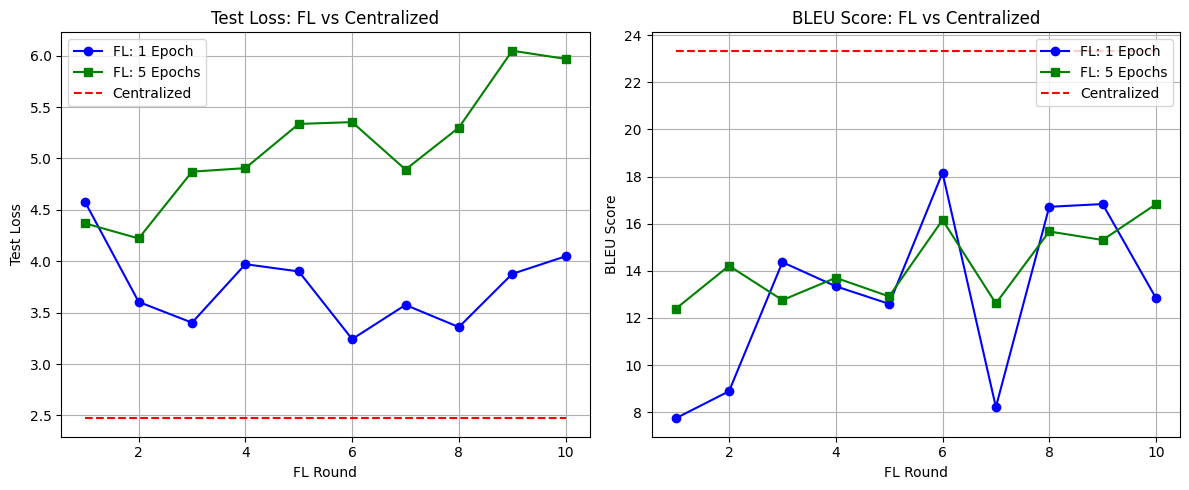

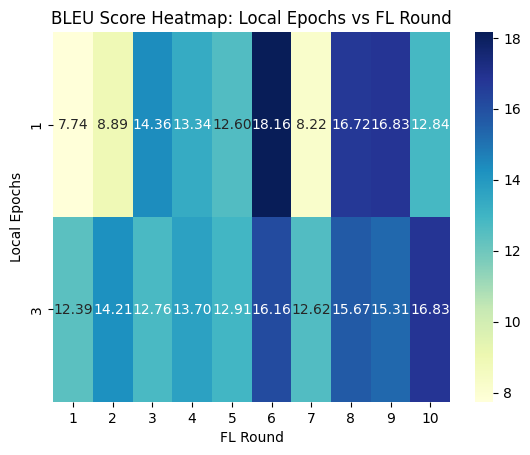

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Extract results
round_test_losses_epoch1, round_bleus_epoch1, _, comm_bytes_epoch1, _, _, _ = results_1_noniid
round_test_losses_epoch3, round_bleus_epoch3, _, comm_bytes_epoch3, _, _, _ = results_2_noniid

# Calculate rounds based on the actual number of rounds run
rounds = list(range(1, len(round_test_losses_epoch1) + 1))

# Test Loss & BLEU vs FL Round
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(rounds, round_test_losses_epoch1, color='blue',marker='o', label='FL: 1 Epoch')
plt.plot(rounds, round_test_losses_epoch3, color='green',marker='s', label='FL: 5 Epochs')
plt.hlines(central_test_loss, 1, len(rounds), colors='red', linestyles='dashed', label='Centralized')
plt.xlabel('FL Round')
plt.ylabel('Test Loss')
plt.title('Test Loss: FL vs Centralized')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(rounds, round_bleus_epoch1, color='blue',marker='o', label='FL: 1 Epoch')
plt.plot(rounds, round_bleus_epoch3, color='green',marker='s', label='FL: 5 Epochs')
plt.hlines(central_bleu, 1, len(rounds), colors='red', linestyles='dashed', label='Centralized')
plt.xlabel('FL Round')
plt.ylabel('BLEU Score')
plt.title('BLEU Score: FL vs Centralized')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



# Heatmap of BLEU: Local Epochs vs FL Round
bleu_matrix = np.array([round_bleus_epoch1, round_bleus_epoch3])
sns.heatmap(bleu_matrix, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=rounds, yticklabels=[1,3])
plt.xlabel('FL Round')
plt.ylabel('Local Epochs')
plt.title('BLEU Score Heatmap: Local Epochs vs FL Round')
plt.show()

### IID Visualization

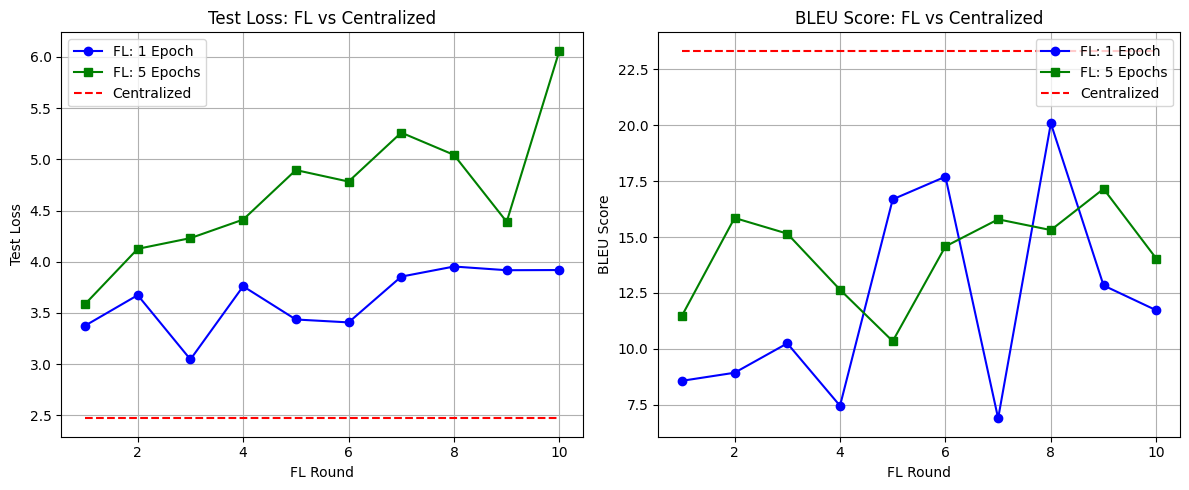

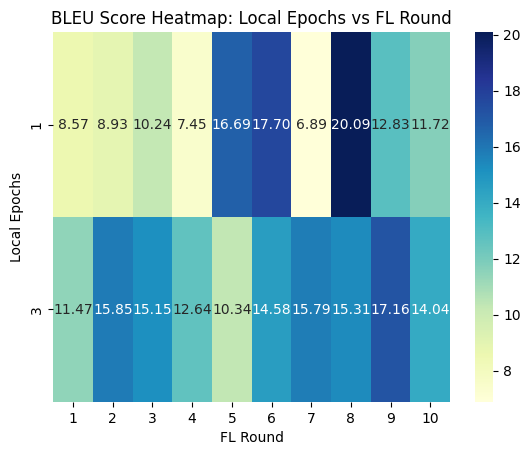

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Extract results
round_test_losses_epoch1, round_bleus_epoch1, _, comm_bytes_epoch1, _, _, _ = results_1_iid
round_test_losses_epoch3, round_bleus_epoch3, _, comm_bytes_epoch3, _, _, _ = results_2_iid

# Calculate rounds based on the actual number of rounds run
rounds = list(range(1, len(round_test_losses_epoch1) + 1))

# Test Loss & BLEU vs FL Round
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(rounds, round_test_losses_epoch1, color='blue',marker='o', label='FL: 1 Epoch')
plt.plot(rounds, round_test_losses_epoch3, color='green',marker='s', label='FL: 5 Epochs')
plt.hlines(central_test_loss, 1, len(rounds), colors='red', linestyles='dashed', label='Centralized')
plt.xlabel('FL Round')
plt.ylabel('Test Loss')
plt.title('Test Loss: FL vs Centralized')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(rounds, round_bleus_epoch1, color='blue',marker='o', label='FL: 1 Epoch')
plt.plot(rounds, round_bleus_epoch3, color='green',marker='s', label='FL: 5 Epochs')
plt.hlines(central_bleu, 1, len(rounds), colors='red', linestyles='dashed', label='Centralized')
plt.xlabel('FL Round')
plt.ylabel('BLEU Score')
plt.title('BLEU Score: FL vs Centralized')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



# Heatmap of BLEU: Local Epochs vs FL Round
bleu_matrix = np.array([round_bleus_epoch1, round_bleus_epoch3])
sns.heatmap(bleu_matrix, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=rounds, yticklabels=[1,3])
plt.xlabel('FL Round')
plt.ylabel('Local Epochs')
plt.title('BLEU Score Heatmap: Local Epochs vs FL Round')
plt.show()


### Communication Overhead: FL vs Centralized

- **Federated Learning (FL)**  
  - Each client trains locally and sends model updates to the server after each round.  
  - Communication overhead is proportional to:  
    Total ≈ 2 × (#params × 4 bytes) × #clients × #rounds
    
  - Therefore: **Estimated communication (MB): 89588.6576**
  - This can be substantial for large models and many clients.  

- **Centralized Training**  
  - All data is on a single machine; training occurs locally.  
  - No model updates are transmitted over the network.  
  - **Communication overhead = 0 MB**.  

> This highlights one key trade-off: FL reduces data sharing but incurs communication cost, whereas centralized training has zero communication but requires all data to be in one place.


### Visualizing Sample Captions  

This cell displays a few test images along with their generated captions for **qualitative evaluation**:  

1. **Federated model predictions**  
   - Shows `N` images from the test set.  
   - Each image displays:  
     - **FED PRED** → caption generated by the federated model (last FL round)  
     - **REF** → ground-truth caption  

2. **Centralized model predictions**  
   - Uses the same images for consistency.  
   - Each image displays:  
     - **CENTRAL PRED** → caption generated by the centralized baseline model  
     - **REF** → ground-truth caption  

> These visual examples help compare **caption quality and differences** between federated and centralized training in an intuitive way.  


### Non-IID Predictions

Federated model examples:


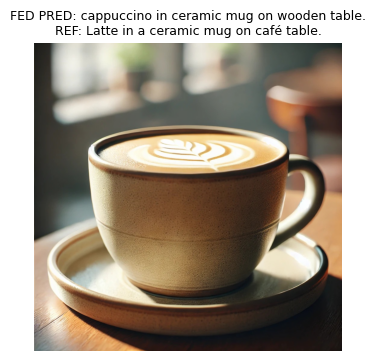

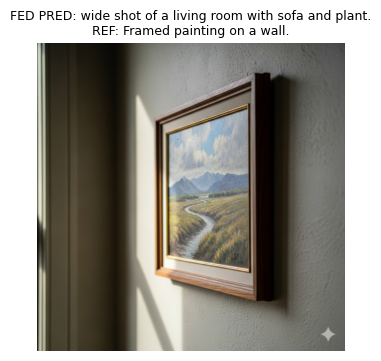

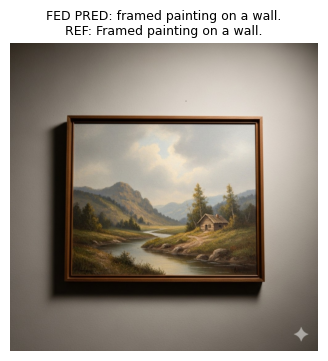

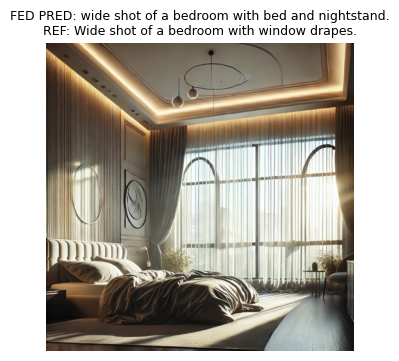

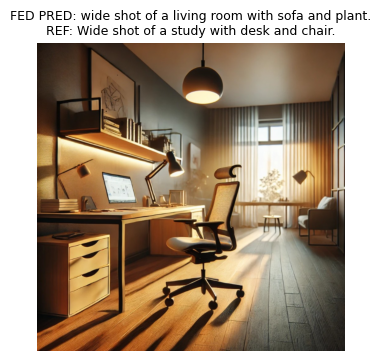

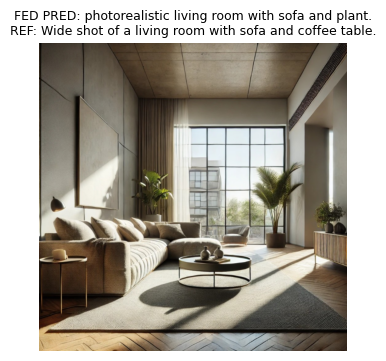

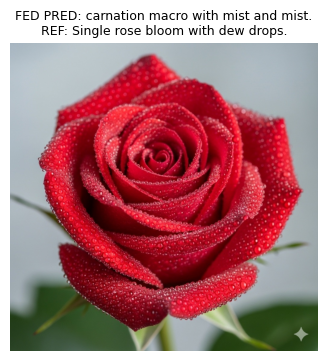

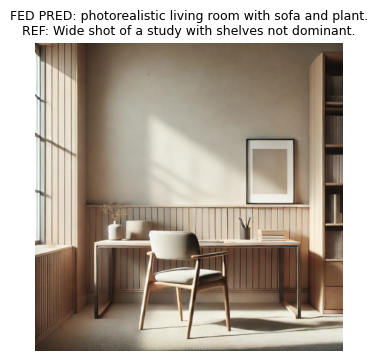

--------------------
Centralized model examples:


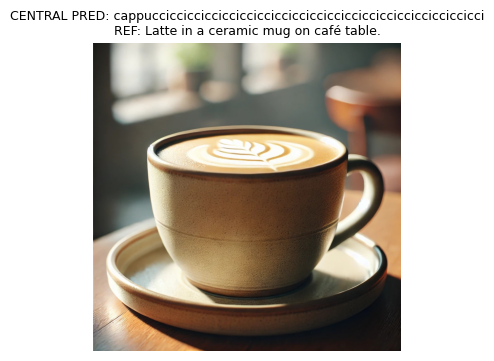

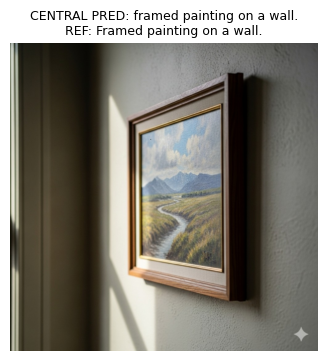

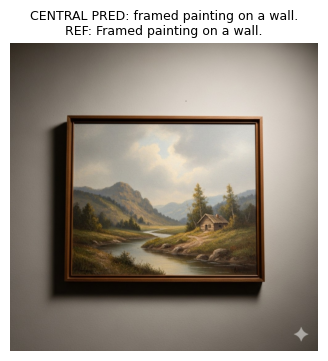

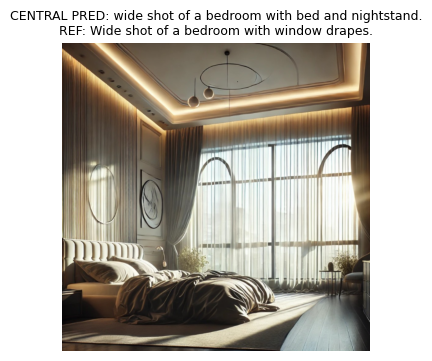

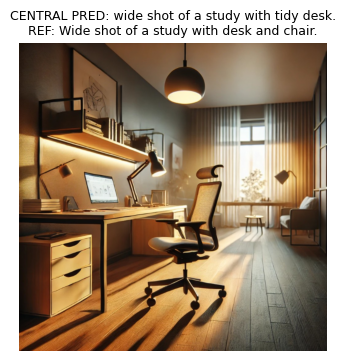

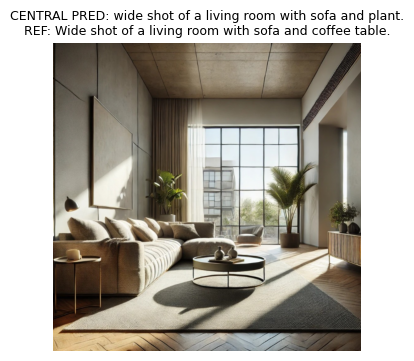

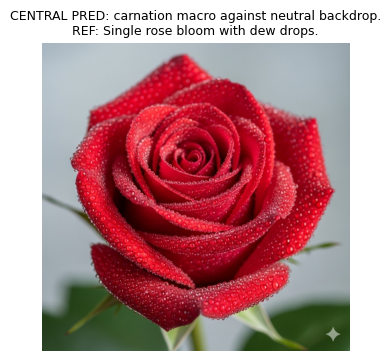

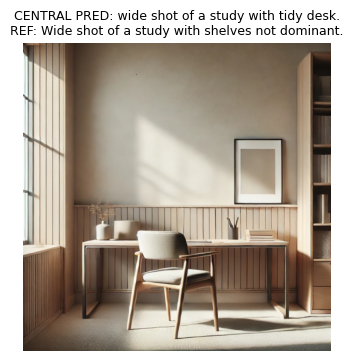

In [30]:
# visualize a few test samples with generated captions
N = min(8, len(fl_img_paths_noniid))

# --- Federated model results ---
print("Federated model examples:")
for i in range(N):
    img = Image.open(fl_img_paths_noniid[i]).convert("RGB")
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"FED PRED: {fl_preds_noniid[i]}\nREF: {fl_refs_noniid[i]}", fontsize=9)
    plt.show()

print("--------------------")

# --- Centralized model results ---
print("Centralized model examples:")
for i in range(N):
    # Use image paths from FL results for consistency
    img = Image.open(fl_img_paths_noniid[i]).convert("RGB")
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"CENTRAL PRED: {preds_c[i]}\nREF: {refs_c[i]}", fontsize=9)
    plt.show()

### IID Predictions

Federated model examples:


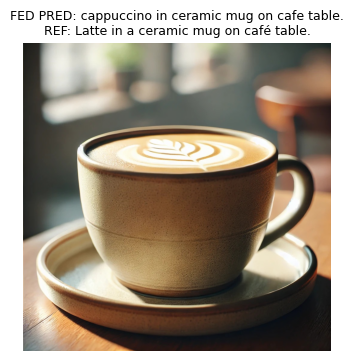

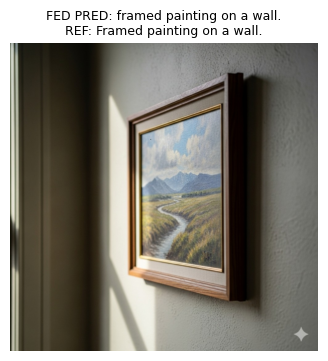

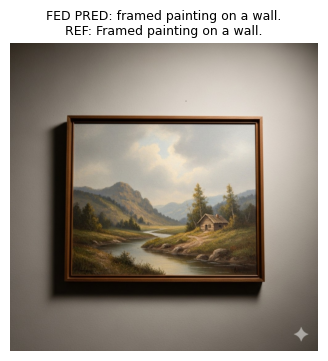

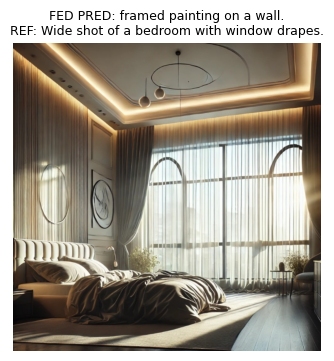

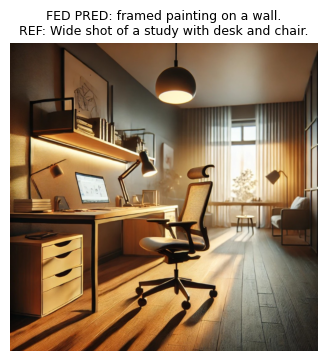

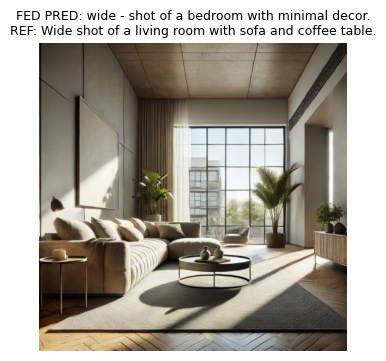

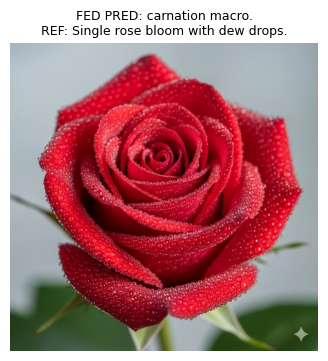

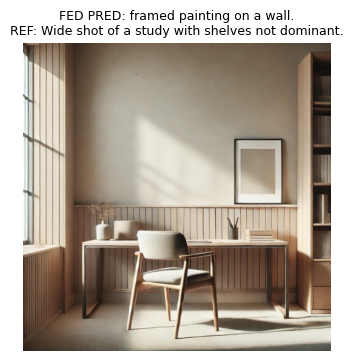

--------------------
Centralized model examples:


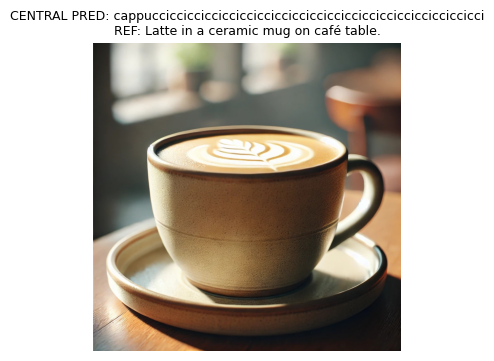

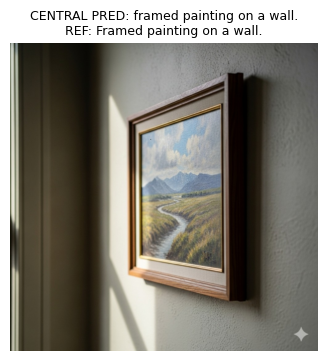

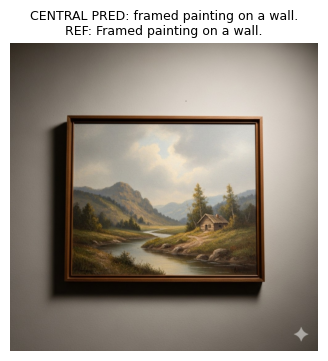

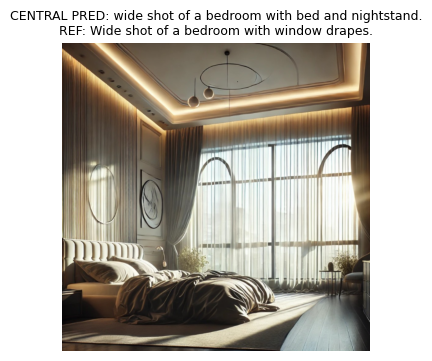

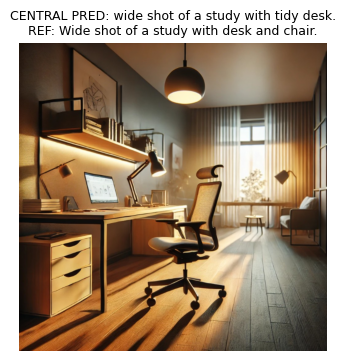

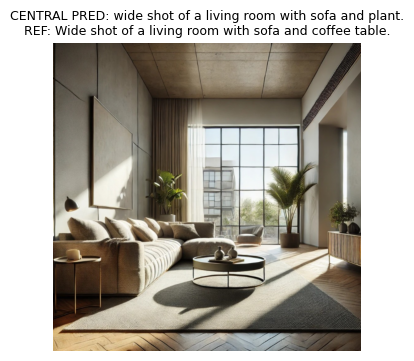

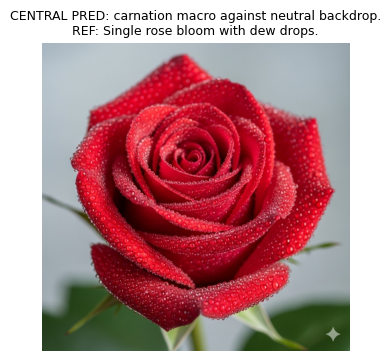

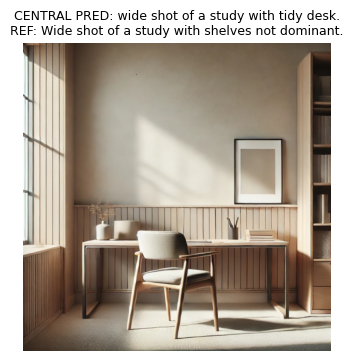

In [31]:
# visualize a few test samples with generated captions
N = min(8, len(fl_img_paths_iid))

# --- Federated model results ---
print("Federated model examples:")
for i in range(N):
    img = Image.open(fl_img_paths_iid[i]).convert("RGB")
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"FED PRED: {fl_preds_iid[i]}\nREF: {fl_refs_iid[i]}", fontsize=9)
    plt.show()

print("--------------------")

# --- Centralized model results ---
print("Centralized model examples:")
for i in range(N):
    # Use image paths from FL results for consistency
    img = Image.open(fl_img_paths_iid[i]).convert("RGB")
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"CENTRAL PRED: {preds_c[i]}\nREF: {refs_c[i]}", fontsize=9)
    plt.show()